In [8]:
import numpy as np
import math as math
import copy
import matplotlib.pyplot as plt
from sklearn import preprocessing 
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
import csv
import cv2
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from scipy.integrate import quad
import sklearn

rows = 5
cols = 5
angular_width = math.pi/4
nnd=2
STD = .1
device = device = torch.device("cuda:0")
datadir = '/home/ephy/Projects/tda_convolution/data/'
generate_data=False

In [284]:
# Rename the distances appropriately
def define_l2_distance(grid, center):
    for i, row in enumerate(grid):
        for j, item in enumerate(row):
            coord = np.absolute(np.subtract((i,j),center))
            grid[i,j] = max(coord)
    return grid

def define_distance(grid, center):
    for i, row in enumerate(grid):
        for j, item in enumerate(row):
            coord = np.subtract((i,j),center)            
            grid[i,j] = np.sqrt(np.sum(np.square(coord)))
    return grid

def define_cmg(rows, cols, nnd):
    center = math.floor(rows/2),math.floor(cols/2) # Floor because of 0-Index
    distance_grid = define_l2_distance(np.zeros([rows,cols]), center)
    perimeter_grid = distance_grid==np.max(distance_grid)

    convolutional_membership_grids = []
    for i, row in enumerate(perimeter_grid):
        for j, item in enumerate(row):
            if(item):
                grid_copy= ((define_distance(np.zeros([rows,cols]), (i,j))<=nnd)*1)*perimeter_grid
                convolutional_membership_grids.append(grid_copy)
    return convolutional_membership_grids

convolutional_membership_grids = define_cmg(rows, cols, nnd)

In [3]:
def integrand(x, k_y, r, m):
    return max( min( r*(x-(m/2.0)) + m/2.0, k_y + 1), k_y ) - k_y

def rotate(matrix, degree):
    degree = int(degree)
    if abs(degree) not in [0, 90, 180, 270, 360]:
        print("ERROR")
        assert(False)
    if degree == 0:
        return matrix
    elif degree > 0:
        return rotate(zip(*matrix[::-1]), degree-90)
    else:
        return rotate(zip(*matrix)[::-1], degree+90)

def primary_circle_weights(m, prim_circle_num):
    tot_angle=2*math.pi
    STD = .1
    list_weights = []
    for w in range(0, int(prim_circle_num)):
        M = np.zeros([int(m), int(m)])
        w = float(w)
        theta = w * (tot_angle) / prim_circle_num
        r = math.sin(theta) / math.cos(theta)

        for x_i in range(0, int(m)):
            for y_i in range(0, int(m)):
                I = quad(integrand, x_i, x_i+1, args=(y_i, r, m))
                sign = np.sign(r)
                if sign == 0: sign = 1
                A = sign * I[0]
                M[y_i, x_i] = A

        if theta > math.pi:
            M = list(rotate(list(rotate(M,90)), 90))
        
        M = np.array(M).flatten()
        M = M - np.mean(M)
        M = sklearn.preprocessing.normalize(np.array([M]), norm='l2', axis=1, copy=True, return_norm=False)[0]
        list_weights.append(M)

    Weights = np.array(list_weights)
    assert round(sum(Weights[0, :]) - 0, 3) == 0
    assert round(np.linalg.norm(Weights[0, :])- 1,3) == 0

    Weights = float(m) * float(STD) * Weights
    assert round(np.std(Weights[0, :])- STD,3) == 0
    assert round(np.std(Weights)- STD,3) == 0
    return Weights

In [30]:
if generate_data:
    infected = glob.glob('../data/original/malaria/Parasitized/*.png')
    uninfected = glob.glob('../data/original/malaria/Uninfected/*.png')
    data = []
    labels = []

    for i in infected:
        try:

            image = cv2.imread(i)
            image_array = Image.fromarray(image , 'RGB')
            resize_img = image_array.resize((50 , 50))
            rotated45 = resize_img.rotate(45)
            rotated75 = resize_img.rotate(75)
            blur = cv2.blur(np.array(resize_img) ,(10,10))
            data.append(np.array(resize_img))
            data.append(np.array(rotated45))
            data.append(np.array(rotated75))
            data.append(np.array(blur))
            labels.append(1)
            labels.append(1)
            labels.append(1)
            labels.append(1)

        except AttributeError:
            continue

    for u in uninfected:
        try:

            image = cv2.imread(u)
            image_array = Image.fromarray(image , 'RGB')
            resize_img = image_array.resize((50 , 50))
            rotated45 = resize_img.rotate(45)
            rotated75 = resize_img.rotate(75)
            data.append(np.array(resize_img))
            data.append(np.array(rotated45))
            data.append(np.array(rotated75))
            labels.append(0)
            labels.append(0)
            labels.append(0)

        except AttributeError:
            continue

    cells = np.array(data)
    labels = np.array(labels)

    np.save('../data/altered/malaria/cells' , cells)
    np.save('../data/altered/malaria/labels' , labels)

In [9]:
cells = np.load('../data/altered/malaria/cells.npy')
labels = np.load('../data/altered/malaria/labels.npy')
cells = cells/255

In [11]:
n = np.arange(cells.shape[0])
np.random.shuffle(n)
cells = cells[n]
labels = labels[n]
cells = cells.astype(np.float32)
labels = labels.astype(np.int32)

train_x , test_x , train_y , test_y = train_test_split(cells , labels , 
                                            test_size = 0.2 ,
                                            random_state = 1)

# eval_x , test_x , eval_y , test_y = train_test_split(x , y , 
#                                                     test_size = 0.5 , 
#                                                     random_state = 1)

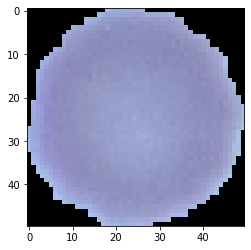

[1 1 1 ... 1 1 0]


In [12]:
plt.imshow(train_x[3])
plt.show()
print(train_y)

In [13]:
# Ballance Training Sample (more one's than zeros)
n = np.arange(sum(train_y==0))
idx = train_y==0
infidx = train_y==1
train_x = np.concatenate([train_x[idx][n], train_x[infidx][n]])
train_y = np.concatenate([train_y[idx][n], train_y[infidx][n]])
# # Re-Randomize
n = np.arange(len(train_y))
np.random.shuffle(n)
train_x = train_x[n]
train_y = train_y[n]
# Put into batches of batch_size
batch_size=100
seq = list(range(0,len(train_x)+1,batch_size))        
train_x=[train_x[n:seq[i+1]] for i,n in enumerate(seq) if i<(len(seq)-1)]
train_y=[train_y[n:seq[i+1]] for i,n in enumerate(seq) if i<(len(seq)-1)]
seq = list(range(0,len(test_x)+1,batch_size))
test_x=[test_x[n:seq[i+1]] for i,n in enumerate(seq) if i<(len(seq)-1)]
test_y=[test_y[n:seq[i+1]] for i,n in enumerate(seq) if i<(len(seq)-1)]

In [124]:
def test_malaria(net):
    correct = 0 
    total = 0
    with torch.no_grad():
        for n, data in enumerate(test_x):
            X = torch.tensor(data).to(device, dtype=torch.float).view(-1, 3, 50, 50)
            y = torch.tensor(test_y[n]).to(device, dtype=torch.long)
            output = net(X)
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]: correct += 1
                total += 1
    return round(correct/total, 3)

In [238]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3)
        self.conv2 = nn.Conv2d(64, 64, 7)
        
        x= torch.randn(50,50,3).view(-1,3,50,50)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 2000)
        self.fc2 = nn.Linear(2000, 500)
        self.fc3 = nn.Linear(500, 100)
        self.fc4 = nn.Linear(100, 2)
        
    def convs(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
            
        return x
    
    def forward(self, x):
        # reshape inside of array
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.softmax(x, dim=1)

In [239]:
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-4)

standard_results=[]
for EPOCH in range(20):
    for i, data in enumerate(train_x):
        X=torch.tensor(data).to(device).view(-1,3,50,50)
        y=torch.tensor(train_y[i]).to(device, dtype=torch.long)
    #     plt.imshow(X.cpu()[2].reshape(50,50,3))
    #     plt.show()
    #     print(y)
    #     break
        net.zero_grad()
        output = net(X)
        loss = F.nll_loss(output, y)
        loss.backward()
        optimizer.step()
        if(((i+1)%100)==0):
            standard_results.append(test_malaria(net))


In [240]:
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-4)

test_weights = [ar.reshape(3,3) for ar in primary_circle_weights(3, 64)]

with torch.no_grad():
        for i,x in enumerate(test_weights):
            net.conv1.weight[i] = torch.nn.Parameter(torch.tensor(test_weights[i])).to(device)

circle_results=[]
for EPOCH in range(20):
    for i, data in enumerate(train_x):
        X=torch.tensor(data).to(device).view(-1,3,50,50)
        y=torch.tensor(train_y[i]).to(device, dtype=torch.long)
    #     plt.imshow(X.cpu()[2].reshape(50,50,3))
    #     plt.show()
    #     print(y)
    #     break
        net.zero_grad()
        output = net(X)
        loss = F.nll_loss(output, y)
        loss.backward()
        optimizer.step()
        if(((i+1)%100)==0):
            circle_results.append(test_malaria(net))

In [228]:
test_weights = np.loadtxt('/home/ephy/Projects/tda_init_cnn/data/altered/legendre_weights_test.txt')
test_weights = [ar.reshape(3,3) for ar in test_weights]

with torch.no_grad():
        for i,x in enumerate(test_weights):
            net.conv1.weight[i] = torch.nn.Parameter(torch.tensor(test_weights[i])).to(device)
            
klein_results=[]
for EPOCH in range(10):
    for i, data in enumerate(train_x):
        X=torch.tensor(data).to(device).view(-1,3,50,50)
        y=torch.tensor(train_y[i]).to(device, dtype=torch.long)
        net.zero_grad()
        output = net(X)
        loss = F.nll_loss(output, y)
        loss.backward()
        optimizer.step()
        if(((i+1)%100)==0):
            klein_results.append(test_malaria(net))

In [226]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3)
        self.conv2 = nn.Conv2d(64, 64, 5)
        
        x= torch.randn(50,50,3).view(-1,3,50,50)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 100)
        self.fc4 = nn.Linear(100, 2)
        
    def convs(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
            
        return x
    
    def forward(self, x):
        # reshape inside of array
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.softmax(x, dim=1)

n_conv_coppies = 4 # How many coppies of each angle (5x5 gives 16 perimeter pixels * 4 is 64 grids)
convolutional_membership_grids_copied = convolutional_membership_grids*n_conv_coppies

net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-4)

test_weights = [ar.reshape(3,3) for ar in primary_circle_weights(3, 64)]

with torch.no_grad():
        for i,x in enumerate(test_weights):
            net.conv1.weight[i] = torch.nn.Parameter(torch.tensor(test_weights[i])).to(device)
        for i,x in enumerate(convolutional_membership_grids):
            tenscopy = torch.tensor(convolutional_membership_grids_copied[i]).to(device)            
            #Copies of copies so we have to loop over sub-copies to keep random weights between all sub-copies
            for ind, weights in enumerate(net.conv2.weight[i]):
                net.conv2.weight[i][ind] = weights*tenscopy

circle_circleConv_results=[]
for EPOCH in range(10):
    for n, data in enumerate(train_x):
        X=torch.tensor(data).to(device).view(-1,3,50,50)
        y=torch.tensor(train_y[i]).to(device, dtype=torch.long)
        net.zero_grad()
        output = net(X)
        loss = F.nll_loss(output, y)
        loss.backward()
        with torch.no_grad():
            for x,param in enumerate(net.conv2.parameters()):
                if(x==0):
                    for i in list(range(param.grad.shape[0])):
                        grad_m = param.grad[i,:,:,:]
                        weights_m = torch.tensor(convolutional_membership_grids_copied[i]).to(device)
                        param.grad[i,:,:,:] = grad_m*weights_m
        optimizer.step()
        if(((n+1)%100)==0):
            circle_circleConv_results.append(test_malaria(net))

In [214]:
n_conv_coppies = 4 # How many coppies of each angle (5x5 gives 16 perimeter pixels * 4 is 64 grids)
convolutional_membership_grids_copied = convolutional_membership_grids*n_conv_coppies

net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-4)

test_weights = np.loadtxt('/home/ephy/Projects/tda_init_cnn/data/altered/legendre_weights_test.txt')
test_weights = [ar.reshape(3,3) for ar in test_weights]

with torch.no_grad():
        for i,x in enumerate(test_weights):
            net.conv1.weight[i] = torch.nn.Parameter(torch.tensor(test_weights[i])).to(device)
        for i,x in enumerate(convolutional_membership_grids):
            tenscopy = torch.tensor(convolutional_membership_grids_copied[i]).to(device)            
            #Copies of copies so we have to loop over sub-copies to keep random weights between all sub-copies
            for ind, weights in enumerate(net.conv2.weight[i]):
                net.conv2.weight[i][ind] = weights*tenscopy

klein_circleConv_results=[]
for EPOCH in range(10):
    for n, data in enumerate(train_x):
        X=torch.tensor(data).to(device).view(-1,3,50,50)
        y=torch.tensor(train_y[i]).to(device, dtype=torch.long)
        net.zero_grad()
        output = net(X)
        loss = F.nll_loss(output, y)
        loss.backward()
        with torch.no_grad():
            for x,param in enumerate(net.conv2.parameters()):
                if(x==0):
                    for i in list(range(param.grad.shape[0])):
                        grad_m = param.grad[i,:,:,:]
                        weights_m = torch.tensor(convolutional_membership_grids_copied[i]).to(device)
                        param.grad[i,:,:,:] = grad_m*weights_m
        optimizer.step()
        if(((n+1)%100)==0):
            klein_circleConv_results.append(test_malaria(net))

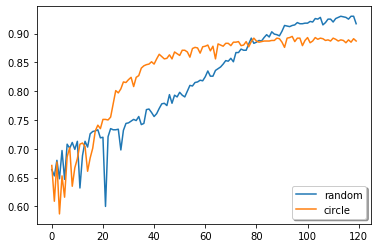

In [237]:
# plt.plot(klein_circleConv_results, label='klein + circle convolve')
# plt.plot(klein_circleConv_results, label='circle + circle convolve')
plt.plot(standard_results, label='random')
plt.plot(circle_results, label='circle')
# plt.plot(klein_results, label='klein')

legend = plt.legend(loc='lower right', shadow=True)
plt.show()

In [197]:
test_malaria(net)

0.434

In [253]:
def test_gray_malaria(net):
    correct = 0 
    total = 0
    with torch.no_grad():
        for n, data in enumerate(test_x):
            data = np.dot(data[...,:3], [0.299, 0.587, 0.114])
            X = torch.tensor(data).to(device, dtype=torch.float).view(-1, 1, 50, 50)
            y = torch.tensor(test_y[n]).to(device, dtype=torch.long)
            output = net(X)
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]: correct += 1
                total += 1
    return round(correct/total, 3)

In [255]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 3)
        self.conv2 = nn.Conv2d(64, 64, 5)
        
        x= torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 100)
        self.fc4 = nn.Linear(100, 2)
        
    def convs(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
            
        return x
    
    def forward(self, x):
        # reshape inside of array
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.softmax(x, dim=1)

net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-4)

test_weights = [ar.reshape(3,3) for ar in primary_circle_weights(3, 64)]

with torch.no_grad():
        for i,x in enumerate(test_weights):
            net.conv1.weight[i] = torch.nn.Parameter(torch.tensor(test_weights[i])).to(device)

gray_results=[]
for EPOCH in range(20):
    for i, data in enumerate(train_x):
        data = np.dot(data[...,:3], [0.299, 0.587, 0.114])
        X=torch.tensor(data).to(device, dtype=torch.float).view(-1,1,50,50)
        y=torch.tensor(train_y[i]).to(device, dtype=torch.long)
        net.zero_grad()
        output = net(X)
        loss = F.nll_loss(output, y)
        loss.backward()
        optimizer.step()
        if(((i+1)%100)==0):
            gray_results.append(test_gray_malaria(net))

In [263]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 3)
        self.conv2 = nn.Conv2d(64, 64, 5)
        
        x= torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 100)
        self.fc4 = nn.Linear(100, 2)
        
    def convs(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
            
        return x
    
    def forward(self, x):
        # reshape inside of array
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.softmax(x, dim=1)

net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-4)

gray_results=[]
for EPOCH in range(20):
    for i, data in enumerate(train_x):
        data = np.dot(data[...,:3], [0.299, 0.587, 0.114])
        X=torch.tensor(data).to(device, dtype=torch.float).view(-1,1,50,50)
        y=torch.tensor(train_y[i]).to(device, dtype=torch.long)
        net.zero_grad()
        output = net(X)
        loss = F.nll_loss(output, y)
        loss.backward()
        optimizer.step()
        if(((i+1)%100)==0):
            gray_results.append(test_gray_malaria(net))

In [268]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 3)
        self.conv2 = nn.Conv2d(64, 64, 5)
        self.conv3 = nn.Conv2d(64, 64, 5)
        
        x= torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 100)
        self.fc4 = nn.Linear(100, 2)
        
    def convs(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
            
        return x
    
    def forward(self, x):
        # reshape inside of array
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.softmax(x, dim=1)

n_conv_coppies = 4 # How many coppies of each angle (5x5 gives 16 perimeter pixels * 4 is 64 grids)
convolutional_membership_grids_copied = convolutional_membership_grids*n_conv_coppies

net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-4)

test_weights = [ar.reshape(3,3) for ar in primary_circle_weights(3, 64)]

with torch.no_grad():
        for i,x in enumerate(test_weights):
            net.conv1.weight[i] = torch.nn.Parameter(torch.tensor(test_weights[i])).to(device)
        for i,x in enumerate(convolutional_membership_grids):
            tenscopy = torch.tensor(convolutional_membership_grids_copied[i]).to(device)            
            #Copies of copies so we have to loop over sub-copies to keep random weights between all sub-copies
            for ind, weights in enumerate(net.conv2.weight[i]):
                net.conv2.weight[i][ind] = weights*tenscopy

gray_circle_circleConv_results=[]
for EPOCH in range(20):
    for n, data in enumerate(train_x):
        data = np.dot(data[...,:3], [0.299, 0.587, 0.114])
        X=torch.tensor(data).to(device, dtype=torch.float).view(-1,1,50,50)
        y=torch.tensor(train_y[i]).to(device, dtype=torch.long)
        net.zero_grad()
        output = net(X)
        loss = F.nll_loss(output, y)
        loss.backward()
        with torch.no_grad():
            for x,param in enumerate(net.conv2.parameters()):
                if(x==0):
                    for i in list(range(param.grad.shape[0])):
                        grad_m = param.grad[i,:,:,:]
                        weights_m = torch.tensor(convolutional_membership_grids_copied[i]).to(device)
                        param.grad[i,:,:,:] = grad_m*weights_m
        optimizer.step()
        if(((n+1)%100)==0):
            gray_circle_circleConv_results.append(test_gray_malaria(net))

In [270]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 3)
        self.conv2 = nn.Conv2d(64, 64, 5)
        
        x= torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 100)
        self.fc4 = nn.Linear(100, 2)
        
    def convs(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
            
        return x
    
    def forward(self, x):
        # reshape inside of array
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.softmax(x, dim=1)

net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-4)

test_weights = np.loadtxt('/home/ephy/Projects/tda_init_cnn/data/altered/legendre_weights_test.txt')
test_weights = [ar.reshape(3,3) for ar in test_weights]

with torch.no_grad():
        for i,x in enumerate(test_weights):
            net.conv1.weight[i] = torch.nn.Parameter(torch.tensor(test_weights[i])).to(device)

gray_klein_results=[]
for EPOCH in range(20):
    for i, data in enumerate(train_x):
        data = np.dot(data[...,:3], [0.299, 0.587, 0.114])
        X=torch.tensor(data).to(device, dtype=torch.float).view(-1,1,50,50)
        y=torch.tensor(train_y[i]).to(device, dtype=torch.long)
        net.zero_grad()
        output = net(X)
        loss = F.nll_loss(output, y)
        loss.backward()
        optimizer.step()
        if(((i+1)%100)==0):
            gray_klein_results.append(test_gray_malaria(net))

In [273]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 3)
        self.conv2 = nn.Conv2d(64, 64, 5)
        self.conv3 = nn.Conv2d(64, 64, 5)
        
        x= torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 100)
        self.fc4 = nn.Linear(100, 2)
        
    def convs(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
            
        return x
    
    def forward(self, x):
        # reshape inside of array
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.softmax(x, dim=1)

n_conv_coppies = 4 # How many coppies of each angle (5x5 gives 16 perimeter pixels * 4 is 64 grids)
convolutional_membership_grids_copied = convolutional_membership_grids*n_conv_coppies

net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-4)

test_weights = np.loadtxt('/home/ephy/Projects/tda_init_cnn/data/altered/legendre_weights_test.txt')
test_weights = [ar.reshape(3,3) for ar in test_weights]

with torch.no_grad():
        for i,x in enumerate(test_weights):
            net.conv1.weight[i] = torch.nn.Parameter(torch.tensor(test_weights[i])).to(device)
        for i,x in enumerate(convolutional_membership_grids):
            tenscopy = torch.tensor(convolutional_membership_grids_copied[i]).to(device)            
            #Copies of copies so we have to loop over sub-copies to keep random weights between all sub-copies
            for ind, weights in enumerate(net.conv2.weight[i]):
                net.conv2.weight[i][ind] = weights*tenscopy

gray_klein_circleConv_results=[]
for EPOCH in range(20):
    for n, data in enumerate(train_x):
        data = np.dot(data[...,:3], [0.299, 0.587, 0.114])
        X=torch.tensor(data).to(device, dtype=torch.float).view(-1,1,50,50)
        y=torch.tensor(train_y[i]).to(device, dtype=torch.long)
        net.zero_grad()
        output = net(X)
        loss = F.nll_loss(output, y)
        loss.backward()
        with torch.no_grad():
            for x,param in enumerate(net.conv2.parameters()):
                if(x==0):
                    for i in list(range(param.grad.shape[0])):
                        grad_m = param.grad[i,:,:,:]
                        weights_m = torch.tensor(convolutional_membership_grids_copied[i]).to(device)
                        param.grad[i,:,:,:] = grad_m*weights_m
        optimizer.step()
        if(((n+1)%100)==0):
            gray_klein_circleConv_results.append(test_gray_malaria(net))

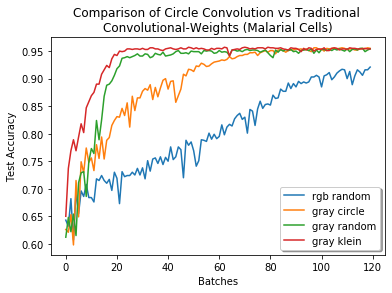

In [276]:
# plt.plot(klein_circleConv_results, label='klein + circle convolve')
# plt.plot(klein_circleConv_results, label='circle + circle convolve')
plt.plot(rgb_results, label='rgb random')
#plt.plot(gray_results, label='gray')
#plt.plot(gray_circle_circleConv_results, label='gray circle + convolve')
plt.plot(circle_results, label='gray circle')
plt.plot(gray_results, label='gray random')
plt.plot(gray_klein_results, label='gray klein')
#plt.plot(gray_klein_circleConv_results, label='gray klein + convolve')
plt.ylabel('Test Accuracy')
plt.xlabel('Batches')
plt.title('Comparison of Circle Convolution vs Traditional \nConvolutional-Weights (Malarial Cells)')
# plt.plot(klein_results, label='klein')

legend = plt.legend(loc='lower right', shadow=True)
plt.show()

In [3]:
import sys
sys.path.insert(0, '/home/ephy/Projects/tda_convolution/src/')
from topnet import *

In [ ]:
results = dict()

configs = dict()

config = dict()
config['weights_config']=[None,None,None]
config['freeze_layers']=[False,False,False]
config['membership_config']=[None,None,None]
config['convLayerSpecs']=[(1,64,3),(64,64,5),(64,64,5)]
config['pools']=[None,[F.max_pool2d,(2,2)],[F.max_pool2d,(2,2)]]
config['activations']=[F.relu, F.relu, F.relu]
config['learning_rate']=1e-3
config['classes']=2
config['imageDim']=(50,50)
config['test_X']=test_X
config['test_y']=test_y
config['train_y']=train_y
config['train_X']=train_X
config['batchesPerTest']=20
config['batchSize']=100
config['epochs']=2
config['dataset']='Malaria Cells'

configs['Normal 3-layer'] = config

results['Malaria Cells'] = run_configs(configs, None)

In [16]:
train_x[0]

array([[[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]